# November 1

Like mesh size in COMSOL, the "BOX_SIZE" should be refined. Think about this later

Task:
- Create dataset of (input, output) images
- Design suitable metadata (distance from separator, etc.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# To read metadata file
import json

# To round up numbers to nearest integer
from math import ceil

# SciKit - input/output
from skimage import io

# SciKit - To rescale image
from skimage.transform import resize

# To save the image
from PIL import Image

# For filesystem manipulation
import os

from typing import Tuple, List

In [2]:
# Co-ordinates but not translated
# Will use these sets of co-ordinates since we'll be working on the
# microstructure image directly.

# Transform circle parameters from JSON metadata file
# from micrometers to pixel scale
def pix_circ_params(x: str,
                    y: str,
                    R: str,
                    params: Tuple[int, int, float]) -> (float, float, float):
    
    DOWN, UP, pix_per_l = params
    
    # Remember that NumPy is weird and defined y=0 from the top
    y_new = DOWN - UP - ceil(pix_per_l * float(y))
    x_new = ceil(pix_per_l * float(x))
    R_new = ceil(pix_per_l * float(R))
    return (x_new, y_new, R_new)

In [3]:
# Retrieves the circle from the colormap based on (x, y, R) from 
# JSON metadata file
def get_color_circle(
    col_map: np.array,
    circ: Tuple[str, str, str],
    mesh: Tuple[np.array, np.array],
    new_dim: Tuple[int, int]) -> np.array:
    
    # Need to copy this else code doesn't work
    col_map = np.copy(col_map)
    
    # Tuple assignment from circle
    x, y, R = circ
    
    # Mesh of electrode geometry
    xx, yy = mesh
    
    # Dimensions to resize high-quality col map to match COMSOL png output
    dX, dY = new_dim
    
    # np.array of booleans where True is a pixel inside a circle
    in_circ = np.sqrt((xx - float(x)) ** 2 + (yy - float(y)) ** 2) <= float(R)
    
    ret_im = col_map
     # "turn off" all pixels outside of current circle
    ret_im[~in_circ] = [0, 0, 0]
    ret_im = resize(ret_im, (dY, dX))
    # Flip image - NumPy does dumb thing with y-axis where it starts from the top 😔
    ret_im = np.flip(ret_im, axis=0)
    return ret_im

# Given the background image of the microstructure, this function returns a new image
# which replaces the background of the circle of interest with its colormap. Original
# dimensions of the colormap is preserved.
def col_particle_to_background(micro_im: np.array, 
                               colored_particle_im: np.array) -> np.array:
    
    # Determine the pixels with color
    colored = np.all(colored_particle_im == [0, 0, 0], axis=-1)
    colored = ~colored
    
    ret_im = np.copy(micro_im)
    # Micro im: remove color from circle of interest
    ret_im[colored] = [0, 0, 0]
    # Micro_im: get RGB to be in float to match col_map
    ret_im = ret_im / 255.0
    ret_im = ret_im + colored_particle_im
    return ret_im

In [4]:
# Define new coordinate transforms
def pix_in_padded(padded_im: np.array, x: str,
                  y: str, pix_per_l: float,
                  pad_width: int) -> (int, int):
    
    dY, dX, _ = padded_im.shape
    y_new = dY - (ceil(pix_per_l * float(y)) + pad_width) 
    x_new = ceil(pix_per_l * float(x)) + pad_width
    return (x_new, y_new)

# Pad image
def pad_image(orig_im: np.array, pad_width: int, pad_type='constant') -> np.array:
    ret_im = np.copy(orig_im)
    ret_im = np.pad(ret_im, 
                    ((pad_width, pad_width), (pad_width, pad_width), (0, 0)),
                    pad_type)
    return ret_im

In [5]:
def extract_input_and_cmap_im(box_size: int,
                              pix_per_l: float,
                              micro_im: np.array,
                              colmap_im: np.array,
                              circ: Tuple[str, str, str],
                              mesh: Tuple[np.array, np.array],
                              new_dim: Tuple[int, int]) -> Tuple[np.array, np.array]:
    '''
    Gets both the input (blank) and labelled (with color) images
    to form machine learning data.
    
    Returns: (input_im, labelled_im)
    '''
    x, y, R = circ
    xx, yy = mesh
    dX, dY = new_dim
    
    # Microstructure image with color in circle of analysis
    with_color = get_color_circle(colmap_im,
                                 (x, y, R),
                                 (xx, yy),
                                 (dX, dY))
    with_color = col_particle_to_background(micro_im, with_color)
    
    padded_with_color = pad_image(with_color, box_size)
    padded_micro = pad_image(micro_im, box_size)
    
    # New coordinates for (x, y) after padding
    x_new, y_new = pix_in_padded(padded_with_color, x, y, pix_per_l, box_size)
    
    input_im = padded_micro[y_new - box_size: y_new + box_size-1, x_new - box_size: x_new + box_size-1, :]
    label_im = padded_with_color[y_new - box_size: y_new + box_size-1, x_new - box_size: x_new + box_size-1, :]
    
    return (input_im, label_im)

In [6]:
# Define the pixel box size
BOX_SIZE = 22 # in pixels

In [7]:
# Original dimensions of half-cell geometry in micrometers
h_cell = 100
L_pos = 176
L_sep = 52
L_foil = L_pos/10

In [8]:
# Electrode boundaries in terms of pixels
# May not need this if we're using the extracted microstructure image
LEFT = 226 + 2 # 226 is where the black border is
RIGHT = 604
UP = 124 + 2 # 124 is where the grey-black border is
DOWN = 339

# We can estimate the pixel/length(um) conversion factor
pix_per_l = (RIGHT - LEFT)/ L_pos
print(pix_per_l)

2.1363636363636362


In [9]:
## Read JSON file
f = open("metadata.json", "r")
ret = json.load(f)

In [10]:
# Output directories
curr_dir = os.getcwd()
dataset_dir = os.path.join(curr_dir, "dataset")
input_image_dir = os.path.join(dataset_dir, "input_images")
label_image_dir = os.path.join(dataset_dir, "labelled_images")

# Creating the directories to store data beforehand
os.mkdir(dataset_dir)
os.mkdir(input_image_dir)
os.mkdir(label_image_dir)

In [11]:
## Datastructure to write output metadata.json
dataset_json = {}

In [12]:
def get_micro_colmaps(microstructure: int,
                     curr_dir: str) -> List[str]:
    '''
    Takes the microstructure being analyzed and being called in the
    same directory where the colour images are being generated. That is,
    being called in the directory where microstructures: 1, 2, 3, etc.; are
    children directories.
    
    Returns a list of filenames corresponding to the generated colormap images.
    '''
    cm_dir = os.path.join(curr_dir, str(microstructure), "col")
    files = os.listdir(cm_dir)
    colmaps = [os.path.join(cm_dir, colmap) for colmap in files]
    return colmaps

In [13]:
def get_colormap_meshgrid(colmap_image: np.array,
                          L: int, 
                          h: int, 
                          scale = 10) -> Tuple[np.array, np.array]:
    '''
    This function takes in the colormap image as well as the geometry
    of the electrode being analyzed and returns a tuple of (xx, yy)
    meshgrid.
    
    L: length of electrode (um)
    h: height/width of electrode (um)
    scale: scale of colmap_image RELATIVE to the original electrode geometry
        - e.g. if L = 176, h = 100, and scale = 10, then (1760, 1000)
    '''
    # Get colormap dimensions for "reference" array for which
    # points are in a circle of interest
    cmY, cmX, _ = colmap_image.shape

    # Meshgrid of coordinates of electrode domain
    x_linspace = np.linspace(0, L, num=L * scale)
    y_linspace = np.linspace(0, h, num=h * scale)

    xx, yy = np.meshgrid(x_linspace, y_linspace)
    
    return xx, yy

In [14]:
def get_exp_params(colmap_fname: str) -> Tuple[str, str]:
    '''
    Retrieves the simulated C-rate and timestep from the
    filename
    
    Returns: (c_rate, time)
    '''
    # Remove the full path, only the filename in form of:
    # - c(c-rate)_t(time).png
    colmap_fname = colmap_fname.split('/')[-1]
    
    temp = colmap_fname.split('.png')
    temp = temp[0]
    temp = temp.split('_t')

    # Get C-rate
    temp1 = temp[0]
    c_rate = temp1[1:]
    
    # Get timestep
    time = temp[1]
    
    return (c_rate, time)

I'm on picture: 1 !
I'm on picture: 263 !
I'm on picture: 525 !
I'm on picture: 787 !
I'm on picture: 1049 !
I'm on picture: 1311 !
I'm on picture: 1573 !
I'm on picture: 1835 !
I'm on picture: 2097 !
I'm on picture: 2359 !
I'm on picture: 2621 !
I'm on picture: 2883 !
I'm on picture: 3145 !
I'm on picture: 3407 !
I'm on picture: 3669 !
I'm on picture: 3931 !
I'm on picture: 4193 !
I'm on picture: 4455 !
I'm on picture: 4717 !
I'm on picture: 4979 !
I'm on picture: 5241 !
I'm on picture: 5503 !
I'm on picture: 5765 !
I'm on picture: 6027 !
I'm on picture: 6289 !
I'm on picture: 6551 !
I'm on picture: 6813 !
I'm on picture: 7075 !
I'm on picture: 7337 !
I'm on picture: 7599 !
I'm on picture: 7861 !
I'm on picture: 8123 !
I'm on picture: 8385 !
I'm on picture: 8647 !
I'm on picture: 8909 !
I'm on picture: 9171 !
I'm on picture: 9333 !
I'm on picture: 9495 !
I'm on picture: 9657 !
I'm on picture: 9819 !
I'm on picture: 9981 !
I'm on picture: 10143 !
I'm on picture: 10305 !
I'm on picture:

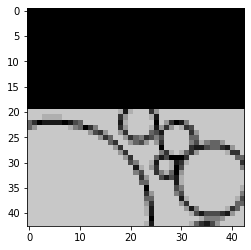

In [15]:
# Variable to store image
pic_num = 1

# For each microstructure, e.g. micros [1, 2, 3, 4, 5]
for i in range(1, 6):
    im = io.imread("microstructure" + str(i) + ".png")
    
    # From source COMSOL image, extract only the electrode domain
    micro_image = im[UP:DOWN, LEFT:RIGHT, :]
    
    # Get dimensions of microstructure image
    dY, dX, _ = np.shape(micro_image)
    
    # Get all colormaps associated with microstructure "i"
    cm_filenames = get_micro_colmaps(i, curr_dir)
    
    # Create meshgrid - any colormap will do; they are the same for the microstucture
    cm = io.imread(cm_filenames[0])
    xx, yy = get_colormap_meshgrid(cm, L_pos, h_cell)
    
    # Load microstructure metadata
    # - i-1 since indexing in Python starts at 0!
    micro_data = ret[i - 1]['circles']
    porosity = ret[i - 1]['porosity']
    tortuosity = ret[i - 1]['tortuosity']
    
    for colormap in cm_filenames:
        # Helpful print statement
        print("I'm on picture:", pic_num, "!")
        cm_image = io.imread(colormap)
        
        # Get the experimental params from filename
        c_rate, time = get_exp_params(colormap)
        
        for particle in micro_data:
            x = particle['x']
            y = particle['y']
            R = particle['R']
            
            input_im, label_im = extract_input_and_cmap_im(BOX_SIZE,
                              pix_per_l,
                              micro_image,
                              cm_image,
                              (x, y, R),
                              (xx, yy),
                              (dX, dY))
            
            # Save input image
            input_fname = os.path.join(input_image_dir, str(pic_num) + ".png")
            input_out = Image.fromarray((input_im).astype(np.uint8))
            input_out.save(input_fname)
            
            plt.imshow(input_out)
            
            # Save label image
            label_fname = os.path.join(label_image_dir, str(pic_num) + ".png")
            label_out = Image.fromarray((label_im * 255).astype(np.uint8))
            label_out.save(label_fname)
            
            # Write metadata to JSON
            dataset_json[pic_num] = []
            dataset_json[pic_num].append({
                'micro': i,
                'x': x,
                'y': y,
                'R': R,
                'c-rate': c_rate,
                'time': time,
                'porosity': porosity,
                'tortuosity': tortuosity,
                'dist_from_sep': float(x)/L_pos,
            })
            
            # Increment picture number here
            pic_num += 1

In [17]:
# Save JSON data
dataset_json_fname = os.path.join(dataset_dir, "dataset.json")

with open(dataset_json_fname, 'w') as outfile:
    json.dump(dataset_json, outfile, indent=4)